## Time Series Analysis and Forecasting for Insurance Sales

This project presents a comprehensive analysis and forecasting focused on an insurance company's daily sales data. The primary goal is to gain insights into sales trends and predict aggregate weekly sales for the next weeks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#### Data preparation

In [2]:
# import the data
data = pd.read_csv('sales_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data

,nb_of_policies
date,
2018-01-01,3
2018-01-02,4
2018-01-03,11
2018-01-04,8
2018-01-05,4
...,...
2021-01-18,20
2021-01-19,46
2021-01-20,55


### Data visualization

In the first step we will visualize the data to identify any trend, seasonality and anomalies.

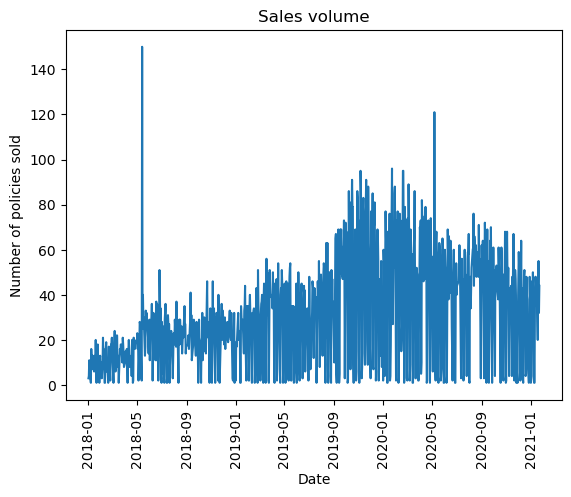

In [3]:
plt.plot(data['nb_of_policies'])
plt.xlabel('Date')
plt.ylabel('Number of policies sold')
plt.title('Sales volume')
plt.xticks(rotation=90)
plt.show()

Based on the plot, we can see that the sales volume is volatile significantly over time. This indicates that the time series may exhibit a trend or seasonality. Therefore, we will characterize its properties.

##### Handling anomalies:

We use Z-score method to replaced the anomalies. We then interpolate them using linear method.

The Z-score method is used to assess how many standard deviations a data point is away from the mean of a dataset and it helps in identifying outliers. Mathematically, the Z-score of a data point 'x' is calculated as:

$Z = \frac{x - \mu}{\sigma}$

We chose this method since it provides a clear and simple interpretation. 

Linear interpolation is a reasonable choice for filling gaps created by anomalies because it assumes a linear relationship between adjacent data points. This is appropriate when we don't have strong reasons to believe that the underlying pattern is more complex.

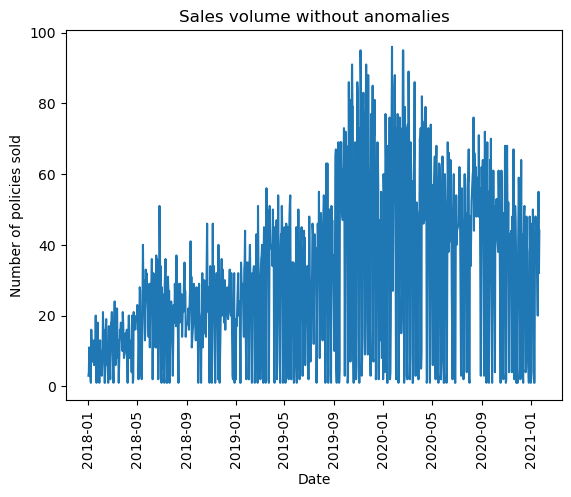

In [4]:
threshold = 3
z_scores = (data - data.mean()) / data.std()
anomalies = z_scores.abs() > threshold
data[anomalies] = np.nan
data = data.interpolate(method='linear')

plt.plot(data['nb_of_policies'])
plt.xlabel('Date')
plt.ylabel('Number of policies sold')
plt.title('Sales volume without anomalies')
plt.xticks(rotation=90)
plt.show()

##### Time series decomposition:

We will decompose the time series into its three components: trend, seasonality, and residual. This would help us identify any patterns in the data. By using it we can better understand which model to use for forecasting.

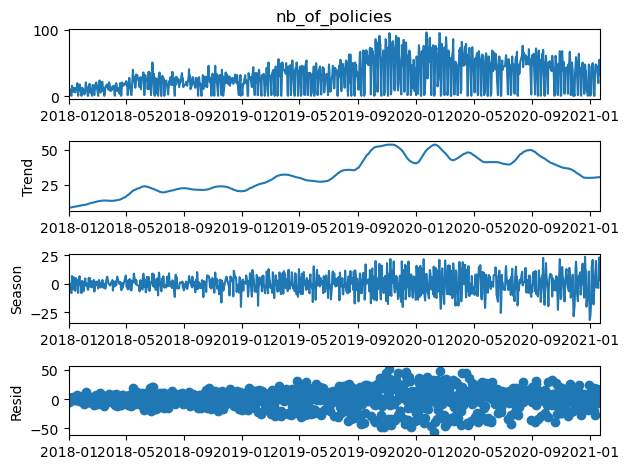

In [5]:
stl = STL(data.nb_of_policies, period=30, seasonal=7)
res = stl.fit()
fig = res.plot()

The plot shows that the trend is not consistent and decreases towards the end, while the seasonality component increases over time. The residual noise indicate that the data becomes more variable when the sales are higher.

##### ADF test

We will check for the presence of a unit root and to determine if the series is stationary or not. If not, we will consider to use data transformation.

In [6]:
result = adfuller(data['nb_of_policies'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("The p-value is greater than 0.05. The time series is non-stationary.")
else:
    print("The p-value is less than or equal to 0.05. The time series is stationary.")

ADF Statistic: -2.2567778339654834
p-value: 0.1862869484843232
The p-value is greater than 0.05. The time series is non-stationary.


We found that the time series is non-stationary, indicating that a more sophisticated modeling approach would be necessary.

#### Smoothing: 

We can reduce the noise in the series by applying smoothing in order to identify the underlying trend when we will try to forecast. 

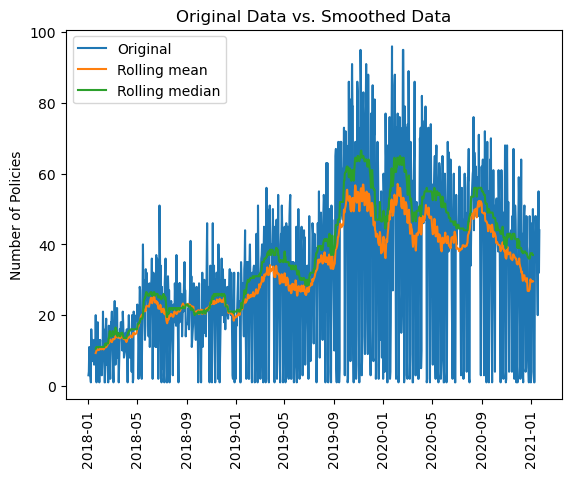

In [7]:
# Define the window size for the rolling window
window_size = 30
# Apply a moving mean or median smoothing technique
rolling_mean = data['nb_of_policies'].rolling(window=window_size, center=True).mean()
rolling_median = data['nb_of_policies'].rolling(window=window_size, center=True).median()

plt.plot(data['nb_of_policies'], label='Original')
plt.plot(rolling_mean, label='Rolling mean')
plt.plot(rolling_median, label='Rolling median')
plt.title('Original Data vs. Smoothed Data')
plt.xticks(rotation=90)
plt.ylabel('Number of Policies')
plt.legend()
plt.show()

However, we still see that the trend is not consistent. Therefore, we will produce a forecast for aggregate values and we will use just the weekly aggregate sales.

Based on the analysis, we found that the time series data is non-stationary, making it difficult to directly apply classical statistical methods. Therefore, we prefer to use a model such as XGBoost, which is designed to handle complex and non-linear relationships.


### Forecasting with XGBoost

#### Data preparation

Train:  107  Test:  53


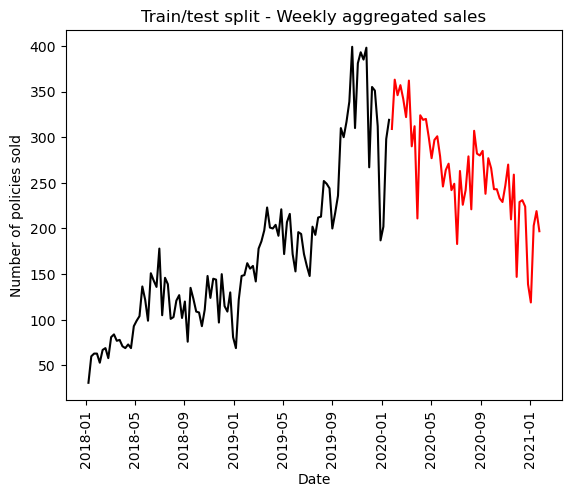

In [8]:
# weekly aggregation
data_weekly = data.resample('W').sum()

# train/test split
train_size = int(len(data_weekly['nb_of_policies']) * 0.67)
test_size = len(data_weekly['nb_of_policies']) - train_size
train, test = data_weekly['nb_of_policies'][0:train_size], data_weekly['nb_of_policies'][train_size:len(data_weekly['nb_of_policies'])]
print('Train: ', len(train), ' Test: ', len(test))

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.xlabel('Date')
plt.ylabel('Number of policies sold')
plt.title('Train/test split - Weekly aggregated sales')
plt.xticks(rotation=90)
plt.show()

We will now transform the time series data into a format suitable for training and will set the hyperparameters for the model. The hyperparameters were chosen through experimentation by trying out several combinations of values and selecting the ones that provided the best performance on the test set.

In [9]:
# prepare the data for training
def prepare_data(timeseries, window_size):
    X, y = [], []
    for i in range(len(timeseries)-window_size):
        X.append(timeseries[i:i+window_size])
        y.append(timeseries[i+window_size])
    return np.array(X), np.array(y)

window_size = 12

train_X, train_y = prepare_data(train, window_size)
test_X, test_y = prepare_data(test, window_size)

# define the parameter grid
param_grid = {
    "eta": [0.1, 0.2, 0.3],
    "max_depth": [3, 4, 5, 8],
    "subsample": [0.5, 0.8, 0.9],
    'learning_rate': [0.1,0.2,0.3,0.5,0.7],
    "colsample_bytree": [0.7, 0.8, 0.9, 1]
}

# create xgboost model and grid search
xgb_model = xgb.XGBRegressor(learning_rate=0.2, n_estimators=100)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(train_X, train_y)

# get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, n_estimators=100)
best_xgb_model.fit(train_X, train_y)

# predictions
pred_y = best_xgb_model.predict(test_X)

rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Test RMSE:", rmse)

Best Parameters: {'colsample_bytree': 1, 'eta': 0.1, 'learning_rate': 0.5, 'max_depth': 4, 'subsample': 0.8}
Test RMSE: 57.64601345023865


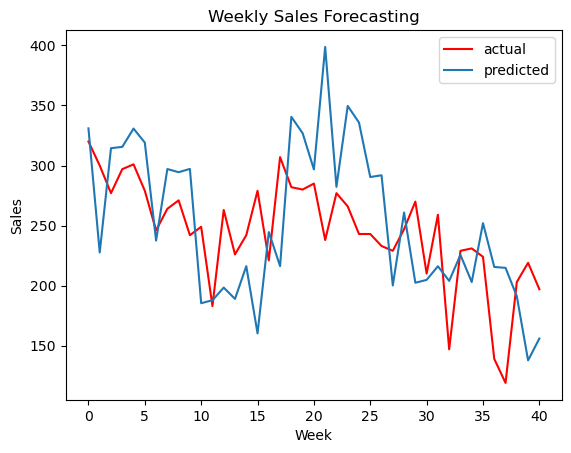

In [10]:
# plot the prediction against the test data
plt.plot(test_y, label='actual', color = "red")
plt.plot(pred_y, label='predicted')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Weekly Sales Forecasting')
plt.legend()
plt.show()

#### Creating a forecast for the next 2 weeks:

In [12]:
# create the dataset for the forecast
last_window = np.array(test_X[-1])

# make predictions
preds = []
for i in range(3):
    # predict next value
    next_pred = best_xgb_model.predict([last_window])
    preds.append(next_pred[0])
    # update the window by shifting values to the left and appending the new prediction
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_pred

print("Predictions for next two weeks:", preds[1:])

Predictions for next two weeks: [130.03433, 217.46481]


By employing a fine-tuned XGBoost model, we generated forecasts for the aggregate weekly sales over the next two weeks. The forecasts will help the insurance company to make informed decisions and optimize their sales strategies in the upcoming weeks.